# Lab 3: Find SVM parameters by SGD/QP
*Author: Dr. Yiru Zhang*

*Computer Science Departement*

*Ecole Supérieure d'Ingénieur Léonard-de-Vinci*

In this lab session, you will implement SVM, a classification algorithm. Even though many well maintained toolboxes exist (such as scikit learn), you must implement this algorithms from scratch, for a better comprehension of the mathematical behind. You will build the following competences:
1. A better understanding of algorithms SVM.
2. Implementation of SGD as an optimization process.
3. Use `qpsolvers` for quadratic programming solution

This work should be done by group of **TWO students (maximum)**.
Please submit GMM (Lab Session 2) and SVM together as one submission.

## Working on generated data
We create two sets of 80 seperable points `X1` and `X2`, then implement a linear SVM model to classify it. The first set is linarly separable, while the second is not.


In [154]:
!pip install qpsolvers


You should consider upgrading via the 'C:\Users\raphv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [155]:
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp

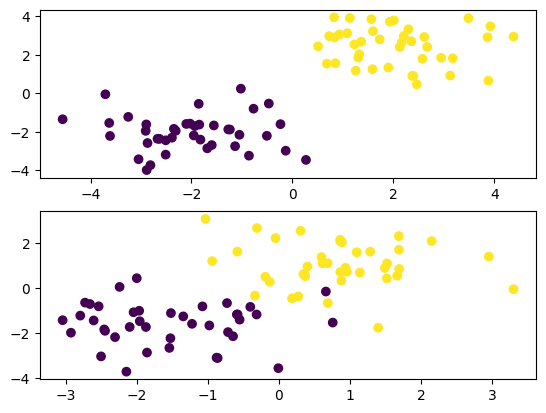

In [156]:
np.random.seed(0)
X1 = np.r_[np.random.randn(40, 2) - [2, 2], np.random.randn(40, 2) + [2, 2]]
X2 = np.r_[np.random.randn(40, 2) - [1.5, 1.5], np.random.randn(40, 2) + [1, 1]]
Y = [-1] * 40 + [1] * 40
#print(X.shape)
fig, axe = plt.subplots(2)
axe[0].scatter(X1[:, 0], X1[:, 1], c=Y)
axe[1].scatter(X2[:, 0], X2[:, 1], c=Y)
plt.show()

In [157]:
# Exemple de données et paramètres
np.random.seed(0)
X_test = np.r_[np.random.randn(40, 2) - [2, 2], np.random.randn(40, 2) + [2, 2]]
Y_test = [-1] * 40 + [1] * 40

# Exemple de paramètres pour le modèle
w_test = np.array([1, -1])  # Exemple de vecteur de poids
b_test = 0.5                 # Exemple de biais

### A. Find parameters by Stochastic Gradient Descent
Given the training data, one general solution is mimizing loss function by gradient descent method.

Recall that a linear Soft SVM is defined as:
$$
\min_{\mathbf{w}, b} \quad \frac{1}{2} {||\mathbf{w}||}^2 +C\sum_{n=1}^N \max \{0,1- y(\mathbf{w}^T\mathbf{x} + b) \} := L
$$
where $\frac{1}{2}||\mathbf{w}||^2$ refers to L2-regularizer and C a regularization parameter (See Slide 18 in Lecture 9)

1. Implement the loss function

In [158]:
def loss(X, Y, C, w, b):
    regularizer = 0.5 * np.dot(w, w)  # régulariser les termes
    error_term = 0
    for i in range(len(X)):
        margin = Y[i] * (np.dot(w, X[i]) + b)
        error_term += max(0, 1 - margin)
    total_loss = regularizer + C * error_term
    return total_loss


2. Implement the gradient
By defining the hinge loss, original optimization problem is converted to a new optimization problem without constraint. Therefore, Gradient descent algorithm can be directly applied to solve it.

#### Answer the following questions, then implement

What is the gradient of the Soft SVM loss function $\nabla L$? Give your answer of $\nabla_wL$ and $\nabla_bL$
(The derivatives are conditional, imposed by $\max \{0,1- y(\mathbf{w}^T\mathbf{x} + b) \}$)


#### Your answer here

$$
\nabla_wL= w−C\sum_{i=1}^N​[yi​⋅xi​⋅1(1−yi​(wTxi​+b)>0)]
$$
$$
\nabla_bL= −C\sum_{i=1}^N​[yi​⋅1(1−yi​(wTxi​+b)>0)]
$$

Then implement:

In [159]:
# Implement the method corresponding to your answer
def derivative_loss(xi, yi, C, w, b):
    """
    Parameters:
    ------------
    xi: (d) array, a data sample
    yi: int, lable of xi
    C: float, slackness for error term
    w:
    b:

    Return:
    -------------
    d_w:
    d_b:
    """
    # To complete
    margin = yi * (np.dot(w, xi) + b)
    if margin < 1:
        # Condition where yi * (w.T * xi + b) < 1
        d_w = w - C * yi * xi
        d_b = -C * yi
    else:
        # Condition where yi * (w.T * xi + b) >= 1
        d_w = w
        d_b = 0
        
    return d_w, d_b

3. implement the learning method

Now you should implement the fitting method, with learning rate $lr$. To remind, the algorithm of SGD is described as follows:
1. Initialize the parameters (w and b, you can initialize them by 1)
2. For every `epoch` in the range of `n_epoch`:
     * iterate on each data sample
     * calculate the derivatives and loss
     * update parameters w and b by `w=w-lr*d_w`, `b=b-lr*d_b`

3. return w and b


In [160]:
def fit_SGD(X, Y, C, lr, max_iter):
    n_samples, n_features = X.shape

    # Initialiser w et b
    w = np.ones(n_features)
    b = 1.0

    for epoch in range(max_iter):
        for i in range(n_samples):
            # Calculer les dérivées et la perte pour chaque échantillon
            d_w, d_b = derivative_loss(X[i], Y[i], C, w, b)

            # Mettre à jour les paramètres
            w = w - lr * d_w
            b = b - lr * d_b

    return w, b

4. Implement the prediction method

Prediction is simple. Since SVM is binary classifier, you just need to see which side of the hyper plane does a data sample fall on.

You can use `np.sign()` to get the sign of each element in a matrix.


In [161]:
def predict(X, w, b):
    """
    Faites une prédiction avec le modèle SVM.

    Parameters:
    ------------
    X : array, les données à prédire
    w : array, le vecteur de poids
    b : float, le biais

    Return:
    ------------
    predictions : array, les prédictions pour chaque échantillon dans X
    """
    predictions = np.sign(np.dot(X, w) + b)
    return predictions


5. Testing on generated data


We are not using conventional evlauation method for classfication, but a more demonstrative method adaptive to our two-dimentional data: Just plot the hyperplane (the line) separating the two classes, with `w` and `b`



In [162]:
def plot_hyperplane(X, Y, w, b):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Créer la grille pour évaluer le modèle
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = np.dot(xy, w) + b

    # Tracer la ligne de décision et les marges
    Z = Z.reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    plt.show()


6. Rewrite your SVM in a python class, with file name `SVM.py`

Just as previous lab session, you need to create a SVM class with parameters `w, b, C, lr, max_iter` as class attributes (with `self`), and methods `_loss()` and  `_derivatie_loss()` as protected methods.
Then, test your code with generated data.

Précision : 100.00%


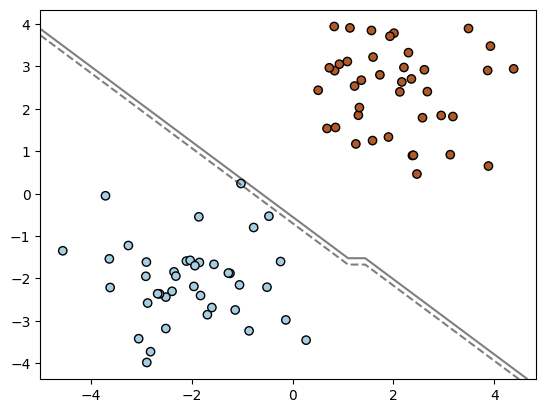

In [169]:
## test with X1 :
import numpy as np
import matplotlib.pyplot as plt
from SVM import SVM

# Génération de données fictives
np.random.seed(0)
X1 = np.r_[np.random.randn(40, 2) - [2, 2], np.random.randn(40, 2) + [2, 2]]
Y = np.array([-1] * 40 + [1] * 40)

# Création d'une instance de SVM
svm = SVM(C=1.0, lr=0.01, max_iter=1000)

# Ajustement du modèle SVM
svm.fit(X1, Y)

# Faire des prédictions
predictions = svm.predict(X1)

# Calcul de la précision
accuracy = np.mean(predictions == Y)
print(f'Précision : {accuracy * 100:.2f}%')

# Visualisation
def plot_hyperplane(X1, Y, model):
    plt.scatter(X1[:, 0], X1[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Création de la grille pour évaluer le modèle
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.predict(xy).reshape(XX.shape)

    # Tracer la ligne de décision et les marges
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()

plot_hyperplane(X1, Y, svm)

In [170]:
C = accuracy
C

1.0

### B. Find Parameters by Quadratic Programming (QP)

During the course, we have learned that

A QP problem is defined as:
$
$\begin{array}{cl}\underset{x}{\operatorname{minimize}} & \frac{1}{2} x^T P x+q^T x \\ \text { subject to } & G x \leq h \\ & A x=b \\ & l b \leq x \leq u b\end{array}$
$



The Lagrangian dual problem of Soft SVM is described by:
<a name="lagrange">
$$
\begin{array}
{cl}\underset{\alpha} {\operatorname{minimize}} & \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N y_i y_j \alpha_i \alpha_j
⟨{x_i},{x_j}⟩ + \sum_{i=1}^N \alpha_i \cr
\text{subject to} \quad& \sum_{i=1}^N y_i \alpha_i =0, \quad 0 \le \alpha_i \le C, \ \forall i=1, \ldots, N
\end{array}
$$
</a>
Attention: in this equation, the variables are $\alpha$. The data $x$ are known values and are used for training process.
The dual function can be therefore rewritten as
$$
\frac{1}{2} \mathbf{𝛂 H 𝛂}^T
 + \mathbf{1}^T \cdot \mathbf{𝛂}
$$
where $\mathbf{H} = y_iy_j⟨{x_i},{x_j}⟩$

Exercise:
1. Assign the correct values to matrix $P, q, G, h, A, b, lb, ub$. Then use qpsolvers to find optimal $\mathbf{𝛂}$.

Read [the manuel of qpsovlers](https://pypi.org/project/qpsolvers/) for more utilisation of this toolbox. `qpsolvers` is not provided by Google Colab by default. If you are using Colab, you need to install it by the following command in a code block.
```
!pip install qpsolvers
```



In [171]:
## ajout suggéré :from scipy.sparse import csc_matrix
from scipy.sparse import csc_matrix

def solve_alpha(X, Y, C):
    N = X.shape[0]  # Nombre d'échantillons
    Y = np.array(Y).reshape(-1, 1) * 1.0  # Convertir Y en une matrice de forme (N,1)
    H = np.dot(Y * X, (Y * X).T)  # Matrice H = y_i * y_j * <x_i, x_j>

    P = H
    q = -np.ones(N)
    G = np.vstack((-np.eye(N), np.eye(N)))
    h = np.hstack((np.zeros(N), np.ones(N) * C))
    A = Y.reshape(1, -1)
    b = np.array([0.])
    
    # Convertir en matrices creuses pour une meilleure performance
    P = csc_matrix(H)
    G = csc_matrix(np.vstack((-np.eye(N), np.eye(N))))
    A = csc_matrix(Y.reshape(1, -1))

    # Choisir le solveur ici, par exemple 'osqp'
    alpha = solve_qp(P, q, G, h, A, b, solver='osqp')
    return alpha


In [172]:

# Utilisez cette fonction avec vos données X, Y et la valeur de C
C = 1.0  
alpha = solve_alpha(X1, Y, C)
print(alpha)

[-1.23184940e-04  4.07187546e-01 -5.36400553e-05  1.60592482e-04
  3.62910742e-04  5.20541121e-04  2.31095179e-04  3.12504471e-04
  1.60773550e-05  1.79376160e-04  2.87035617e-04  1.24317390e-04
 -9.12910649e-05  2.72335214e-04 -2.97589257e-05  3.46203800e-04
  1.62539087e-04  3.31479634e-04  2.13749797e-04  2.77151637e-04
  1.97935876e-04  3.69040742e-04  2.65537989e-04  3.62878401e-04
  2.78440260e-04  3.48513541e-04  2.00391560e-04  3.63690492e-04
  3.39685866e-04  2.74649248e-04  2.75350941e-04  1.74278748e-04
  2.36988825e-04  3.21847230e-04  3.14467167e-04  2.37933962e-04
  6.10328025e-05  1.86671264e-04  2.56969498e-04  3.17754576e-04
  2.44004918e-04  7.38130477e-04  2.37323230e-04  4.38832732e-04
  2.33584691e-04  2.66513123e-04  3.19877025e-04  3.58055475e-04
  2.25021460e-04  4.10432579e-04  4.50001395e-04  2.20646560e-04
  1.39535772e-04  7.40241621e-04  2.60462772e-04  3.01086423e-04
  1.66307729e-04  3.35281285e-04  4.55491561e-04  3.27442003e-04
  6.96207094e-04  2.79039

Once the values of $𝛂$ is found, you can calulate the parameters $\mathbf{w}$ and $\mathbf{b}$ in the SVM.
Calculate $\mathbf{w}$ from equation D1 in Slide 21 of Lecture 9:
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n y_n \mathbf{x}_n
$$
Then, the bias $b$ is calculated by:
$$
b=(1/N)\sum_{i=1}^N(y_i-\sum_{j=1}^Na_jy_jx_j^Tx_i)
$$

2. Implement the fitting method by QP solver `fit_QP()` in your SVM class.
Then test your code with generated data. You can also integrate this method in the SVM class.

In [ ]:

## ajouté dans SVM.py
"""
def fit_QP(self, X, Y, C):
        alpha = self.solve_alpha(X, Y, C)  # Assurez-vous que cette méthode est définie pour résoudre les alphas.
        self.w = self.calculate_w(X, Y, alpha)
        self.b = self.calculate_b(X, Y, alpha, self.w)
        return self.w, self.b
"""

'\ndef fit_QP(self, X, Y, C):\n        alpha = self.solve_alpha(X, Y, C)  # Assurez-vous que cette méthode est définie pour résoudre les alphas.\n        self.w = self.calculate_w(X, Y, alpha)\n        self.b = self.calculate_b(X, Y, alpha, self.w)\n        return self.w, self.b\n'

In [168]:
import importlib
import SVM
importlib.reload(SVM)
from SVM import SVM
svm_model = SVM()

In [173]:
# Ajustement du modèle SVM en utilisant le solveur QP
w, b = svm_model.fit_QP(X1, Y)
w,b

(array([0.7442811 , 0.56678164]), -0.11990414497618951)

3. Again, plot the fitted hyperplane with the data, with learned `w` and `b`.

Précision : 100.00%


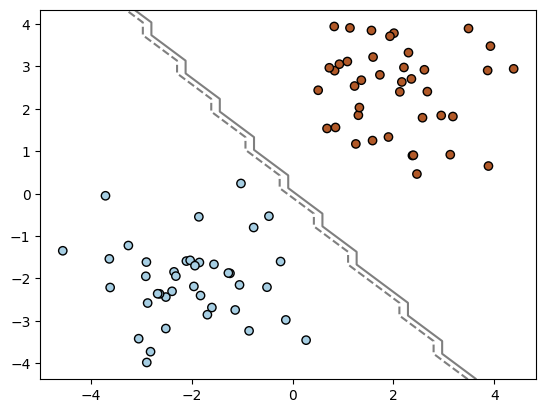

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from SVM import SVM  # Assurez-vous que c'est le chemin correct vers votre fichier SVM.py

# Génération de données fictives
np.random.seed(0)
X1 = np.r_[np.random.randn(40, 2) - [2, 2], np.random.randn(40, 2) + [2, 2]]
Y = np.array([-1] * 40 + [1] * 40)

# Création d'une instance de SVM et ajustement du modèle SVM
svm_model = SVM(C=1.0, lr=0.01, max_iter=1000)
w, b = svm_model.fit_QP(X1, Y)  # Assurez-vous que fit renvoie les bons paramètres w et b

# Faire des prédictions et calculer la précision
predictions = svm_model.predict(X1)
accuracy = np.mean(predictions == Y)
print(f'Précision : {accuracy * 100:.2f}%')

# Fonction pour tracer l'hyperplan
def plot_hyperplane(X, Y, model):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Création de la grille pour évaluer le modèle
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.predict(xy).reshape(XX.shape)

    # Tracer la ligne de décision et les marges
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()

plot_hyperplane(X1, Y, svm_model)


## C. SVM with RBF kernel (Optional)

As explained in the lecture, you can implement kernel function to transform the data points into a highier dimentional space, to make the non-separable data separable (linearly). The transformation is simple. Instead of calculating the inner product ($k(x_i,x_j)=⟨{x_i},{x_j}⟩$) in [the Lagrange Dual function](#lagrange), you should apply a transformation
$$
k(x_i,x_j) = exp(\gamma ||x_i-x_j||^2)
$$
where $exp(⋅)$ is an exponential function, $\gamma$ a hyperparameter defined by the user, and $||⋅||^2$ the L2 norm.


In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix

class SVM:
    def __init__(self, C=1.0, lr=0.01, max_iter=1000):
        self.C = C
        self.lr = lr
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def _loss(self, X, Y):
        regularizer = 0.5 * np.dot(self.w, self.w)
        error_term = sum(max(0, 1 - y * (np.dot(self.w, x) + self.b)) for x, y in zip(X, Y))
        total_loss = regularizer + self.C * error_term
        return total_loss

    def _derivative_loss(self, xi, yi):
        margin = yi * (np.dot(self.w, xi) + self.b)
        if margin < 1:
            d_w = self.w - self.C * yi * xi
            d_b = -self.C * yi
        else:
            d_w = self.w
            d_b = 0
        return d_w, d_b
    
    def fit_SGD(self, X, Y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0

        for epoch in range(self.max_iter):
            # Shuffle the data
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            for i in range(n_samples):
                d_w, d_b = self._derivative_loss(X_shuffled[i], Y_shuffled[i], self.w, self.b)

                # Update parameters
                self.w -= self.lr * d_w
                self.b -= self.lr * d_b

        return self.w, self.b


    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

    def solve_alpha(self, X, Y):
        N = X.shape[0]  # Nombre d'échantillons
        Y = np.array(Y).reshape(-1, 1) * 1.0  # Convertir Y en une matrice de forme (N,1)
        H = np.dot(Y * X, (Y * X).T)  # Matrice H = y_i * y_j * <x_i, x_j>

        P = H
        q = -np.ones(N)
        G = np.vstack((-np.eye(N), np.eye(N)))
        h = np.hstack((np.zeros(N), np.ones(N) * self.C))
        A = Y.reshape(1, -1)
        b = np.array([0.])
    
        # Convertir en matrices creuses pour une meilleure performance
        P = csc_matrix(H)
        G = csc_matrix(np.vstack((-np.eye(N), np.eye(N))))
        A = csc_matrix(Y.reshape(1, -1))

        # Utiliser le solveur 'osqp'
        alpha = solve_qp(P, q, G, h, A, b, solver='osqp')
        return alpha

    def calculate_w(self, X, Y, alpha):
        return np.sum((alpha * Y)[:, np.newaxis] * X, axis=0)

    def calculate_b(self, X, Y, alpha, w):
        b_sum = 0
        for i in range(len(Y)):
            b_sum += (Y[i] - np.sum(alpha * Y * np.dot(X, X[i])))
        return b_sum / len(Y)
        
    def fit_QP(self, X, Y):
        alpha = self.solve_alpha(X, Y)  # Utilise la méthode solve_alpha pour obtenir les alphas.
        self.w = self.calculate_w(X, Y, alpha)
        self.b = self.calculate_b(X, Y, alpha, self.w)
        return self.w, self.b

    @staticmethod
    @staticmethod
    def RBF(X, x, gamma):
        # Ensure both inputs are 2D arrays, where each row represents a single data point
        X = np.atleast_2d(X)
        x = np.atleast_2d(x)
        # Compute the squared L2 distance between each pair of points
        squared_norm = np.sum((X[:, np.newaxis, :] - x[np.newaxis, :, :]) ** 2, axis=2)
        # Apply the RBF kernel function element-wise
        K = np.exp(-gamma * squared_norm)
        return K



    def solve_alpha_RBF(self, X, Y, gamma):
        N = X.shape[0]
        Y = np.array(Y).reshape(-1, 1) * 1.0
        K = self.RBF(X, X, gamma)

        P = Y * Y.T * K
        q = -np.ones(N)
        G = np.vstack((-np.eye(N), np.eye(N)))
        h = np.hstack((np.zeros(N), np.ones(N) * self.C))
        A = Y.reshape(1, -1)
        b = np.array([0.])

        P = csc_matrix(P)
        G = csc_matrix(G)
        A = csc_matrix(A)

        # Solving QP problem
        alpha = solve_qp(P, q, G, h, A, b, solver='osqp')
        return alpha

    def calculate_b_RBF(self, X, Y, alpha, gamma):
        support_vectors_idx = (alpha > 1e-5).flatten()
        support_vectors = X[support_vectors_idx]
        support_vector_labels = Y[support_vectors_idx]
        alpha_sv = alpha[support_vectors_idx]

        # Calculate the RBF kernel only between support vectors
        K_sv = self.RBF(support_vectors, gamma)

        # Calculate b using only support vectors
        b = support_vector_labels - np.dot(K_sv, alpha_sv * support_vector_labels)
        return np.mean(b)


    def fit_QP_RBF(self, X, Y, gamma):
        alpha = self.solve_alpha_RBF(X, Y, gamma)
        self.b = self.calculate_b_RBF(X, Y, alpha, gamma)
        self.support_vectors_ = X[alpha.flatten() > 1e-5]
        self.support_vector_labels_ = Y[alpha.flatten() > 1e-5]
        self.alpha_ = alpha[alpha.flatten() > 1e-5]
        # No self.w for kernel methods
        return self.support_vectors_, self.support_vector_labels_, self.alpha_, self.b
    
    def predict_RBF(self, X, gamma=None):
        if self.w is not None:
            # Linear prediction
            return np.sign(np.dot(X, self.w) + self.b)
        elif gamma is not None:
            # Kernel prediction, using support vectors and the RBF kernel
            y_predict = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                kernel_value = self.RBF(self.support_vectors_, X[i, :], gamma)
                y_predict[i] = np.sum(
                    self.alpha_ * self.support_vector_labels_ * kernel_value
                )
            return np.sign(y_predict + self.b)
        else:
            raise ValueError("The model is not fitted yet or gamma is not provided for kernel prediction.")

Test your code with ensercled data samples, generated as follows.

In [196]:
import importlib
import SVM
importlib.reload(SVM)
from SVM import SVM
svm_model = SVM()

In [197]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Generate circular data
X_circle, y_circle = make_circles(n_samples=500, noise=0.06, random_state=42)

# Feature scaling (if not already done)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_circle)

# Define ranges for gamma and C
gamma_values = np.linspace(0.05, 0.15, 5)  # Refined range around 0.1
C_values = [0.1, 1, 10]

# Placeholder for the best score and corresponding hyperparameters
best_score = 0
best_params = {'C': None, 'gamma': None}

# Use StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search over gamma and C
for gamma in gamma_values:
    for C in C_values:
        cv_scores = []
        for train_index, val_index in kf.split(X_scaled, y_circle):
            # Split data
            X_train, X_val = X_scaled[train_index], X_scaled[val_index]
            y_train, y_val = y_circle[train_index], y_circle[val_index]
            
            # Create and fit the model
            svm_model = SVM(C=C, lr=0.01, max_iter=1000)
            svm_model.fit_QP_RBF(X_train, y_train, gamma)
            
            # Evaluate on validation set
            predictions = svm_model.predict_RBF(X_val, gamma)
            score = accuracy_score(y_val, predictions)
            cv_scores.append(score)
        
        # Average CV score
        avg_score = np.mean(cv_scores)
        
        # Update best score
        if avg_score > best_score:
            best_score = avg_score
            best_params = {'C': C, 'gamma': gamma}

# Output the best parameters and score
print(f'Best params: {best_params}')
print(f'Best cross-validation score: {best_score}')


Best params: {'C': 0.1, 'gamma': 0.05}
Best cross-validation score: 0.5


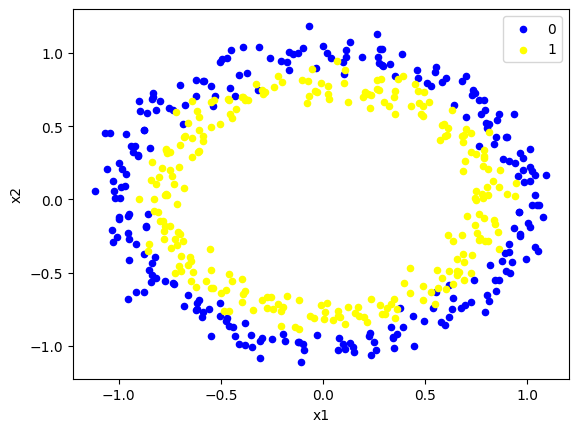

In [192]:
import pandas as pd
from sklearn.datasets import make_circles

# Generate circular data
X_circle, y_circle = make_circles(n_samples=500, noise=0.06, random_state=42)

# Create an instance of the SVM class
svm_model = SVM(C=1.0, lr=0.01, max_iter=1000)

# Fit the model with RBF kernel
gamma_value = 2.0  # Tune this value based on your dataset
svm_model.fit_QP_RBF(X_circle, y_circle, gamma_value)

# Visualize the data and the decision boundary
df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))
colors = {0:'blue', 1:'yellow'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()



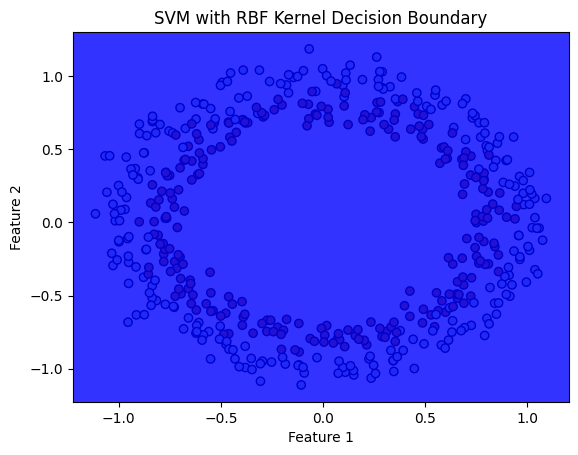

In [198]:
def plot_hyperplane(X, Y, model, gamma):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Creating a grid to evaluate the model
    xx = np.linspace(xlim[0], xlim[1], 200)  # Increased resolution for a finer grid
    yy = np.linspace(ylim[0], ylim[1], 200)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Use predict_RBF for predictions and pass gamma
    Z = model.predict_RBF(xy, gamma).reshape(XX.shape)

    ax.contourf(XX, YY, Z, levels=[-1, 0, 1], colors=['blue', 'lightblue', 'pink'], alpha=0.8)

    # Plotting the decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM with RBF Kernel Decision Boundary')
    plt.show()

best_C = 0.1  
best_gamma = 0.05  
svm_model.fit_QP_RBF(X_circle, y_circle, best_gamma)

# Call the plot function with the trained model and best gamma
plot_hyperplane(X_circle, y_circle, svm_model, best_gamma)


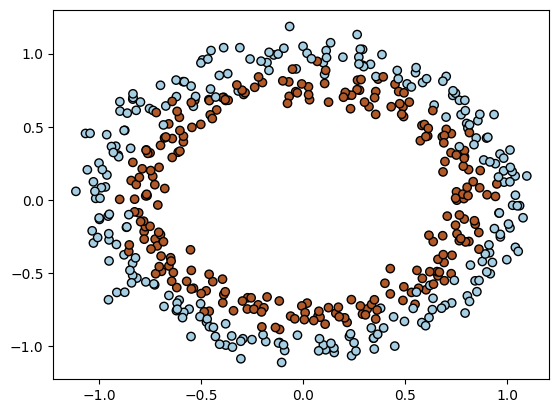

In [178]:
gamma_value = 2.0  
plot_hyperplane(X_circle, y_circle, svm_model, gamma_value)


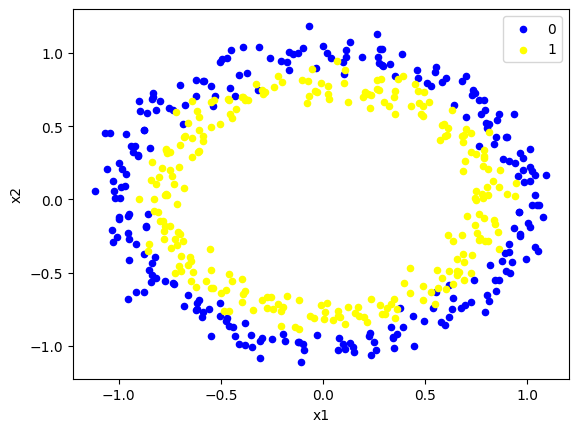

In [180]:
import pandas as pd
from sklearn.datasets import make_circles
X_circle, y_circle = make_circles(n_samples=500, noise=0.06, random_state=42)
df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))
colors = {0:'blue', 1:'yellow'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()